In [1]:
import autograd.numpy as np
from autograd import grad
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('whitegrid')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def hamiltonian(qp):
    q_x = qp[0]
    q_y = qp[1]
    p_x = qp[2]
    p_y = qp[3]
    return (p_x**2 + p_y**2) / 2 - 9.81 * q_y

In [4]:
def dhdq_func(qp):
    return [0, 9.81]

def dhdp_func(qp):
    p_x = qp[2]
    p_y = qp[3]
    return [p_x, p_y]

In [5]:
def symplectic(t, qp):
    dhdq = np.array(dhdq_func(qp))
    dhdp = np.array(dhdp_func(qp))
    return np.array([dhdp, -dhdq]).flatten()

In [6]:
def hit_ground(t, u):
    return u[1]

hit_ground.terminal = True
hit_ground.direction = 0

In [7]:
def horizontal_throw(energies, t_span, t_points):
    q = []
    p = []

    q_dot = []
    p_dot = []

    t_eval = np.linspace(t_span[0], t_span[1], t_points)

    for E in energies:
        t = np.random.uniform(0, 2)
        qy_init = 50
        qx_init = 0
        px_init = np.sqrt(2 * E + 2 * 9.81)
        py_init = 0
        y0 = np.array([[qx_init, qy_init], [px_init, py_init]])
        
        symplectic_ivp = solve_ivp(fun=symplectic, t_span=t_span, y0=y0.flatten(), t_eval=t_eval, events=hit_ground)
        t_points = len(symplectic_ivp['y'][0])

        q.append(np.array([symplectic_ivp['y'][0] + np.random.normal(0, 0.2, t_points), symplectic_ivp['y'][1] + np.random.normal(0, 0.2, t_points)]))
        p.append(np.array([symplectic_ivp['y'][2] + np.random.normal(0, 0.2, t_points), symplectic_ivp['y'][3] + np.random.normal(0, 0.2, t_points)]))
        
        dots = np.array([np.array(symplectic(None, qp)) for qp in symplectic_ivp['y'].T])

        q_dot.append(np.array([dots[:,0], dots[:,1]]))
        p_dot.append(np.array([dots[:,2], dots[:,3]]))
            
    q = np.array(q)
    p = np.array(p)

    q_dot = np.array(q_dot)
    p_dot = np.array(p_dot)

    return q, p, q_dot, p_dot

In [8]:
def diff_hnn(model, qp):
    qp = torch.autograd.Variable(qp, requires_grad=True).to(device)
    out = torch.autograd.grad(model(qp).sum(), qp, create_graph=True)[0].to(device)
    M = torch.Tensor([[0, 0, 0, -1], [0, 0, -1, 0], [0, 1, 0, 0], [1, 0, 0, 0]]).to(device)

    return model(qp).sum(), out @ M

In [9]:
energies = np.random.uniform(0.2, 40, 10000)

In [10]:
q, p, q_dot, p_dot = horizontal_throw(energies, [0, 5], 100)

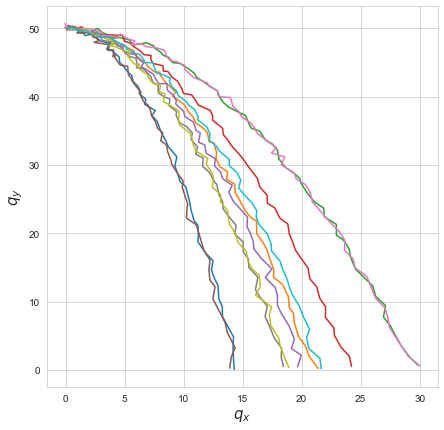

In [11]:
plt.figure(figsize=(7,7))
for i in range(10): 
    plt.plot(q[i][0], q[i][1])

plt.xlabel(r'$q_x$', size=15)
plt.ylabel(r'$q_y$', size=15)
plt.show()

In [12]:
q = np.array([q[i].T for i in range(q.shape[0])])
p = np.array([p[i].T for i in range(p.shape[0])])
q_dot = np.array([q_dot[i].T for i in range(q_dot.shape[0])])
p_dot = np.array([p_dot[i].T for i in range(p_dot.shape[0])])

In [13]:
X = np.concatenate((q,p), axis=2)
y = np.concatenate((q_dot,p_dot), axis=2)
print(X[0][0])
print(y[0][0])

[-0.06381982 50.11184488  4.40264792  0.24072736]
[ 4.60141216  0.         -0.         -9.81      ]


In [14]:
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).to(device)
X.shape

torch.Size([10000, 64, 4])

In [15]:
train_X, test_X = np.split(X, 2, axis=0)
train_y, test_y = np.split(y, 2, axis=0)

In [16]:
# Models

In [17]:
from models import MLP, HNN

baseline = MLP(dims=2).to(device)
hnn_model = HNN(dims=2).to(device)

In [18]:
trainset = torch.utils.data.TensorDataset(train_X, train_y)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True, num_workers=0)

In [19]:
import torch.optim as optim

optimizer1 = optim.Adam(baseline.parameters(), lr=1e-3)
optimizer2 = optim.Adam(hnn_model.parameters(), lr=1e-3)

In [20]:
%%time
# baseline training
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = baseline(inputs)
        loss = ((outputs - labels)**2).mean()
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if (epoch + 1) % 20 == 0:
            print('Epoch: %d | MSE Loss: %.5f' % (epoch + 1, running_loss))
            running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')

Epoch: 20 | MSE Loss: 0.07284
Epoch: 20 | MSE Loss: 0.07415
Epoch: 20 | MSE Loss: 0.06807
Epoch: 20 | MSE Loss: 0.07248
Epoch: 20 | MSE Loss: 0.06789
Epoch: 20 | MSE Loss: 0.06666
Epoch: 20 | MSE Loss: 0.07461
Epoch: 20 | MSE Loss: 0.06112
Epoch: 20 | MSE Loss: 0.06592
Epoch: 20 | MSE Loss: 0.06696
Epoch: 20 | MSE Loss: 0.07061
Epoch: 20 | MSE Loss: 0.07185
Epoch: 20 | MSE Loss: 0.06815
Epoch: 20 | MSE Loss: 0.06426
Epoch: 20 | MSE Loss: 0.06978
Epoch: 20 | MSE Loss: 0.06564
Epoch: 20 | MSE Loss: 0.06474
Epoch: 20 | MSE Loss: 0.06411
Epoch: 20 | MSE Loss: 0.06576
Epoch: 20 | MSE Loss: 0.06563
Epoch: 20 | MSE Loss: 0.06095
Epoch: 20 | MSE Loss: 0.06293
Epoch: 20 | MSE Loss: 0.06673
Epoch: 20 | MSE Loss: 0.06625
Epoch: 20 | MSE Loss: 0.06117
Epoch: 40 | MSE Loss: 0.01425
Epoch: 40 | MSE Loss: 0.01473
Epoch: 40 | MSE Loss: 0.01422
Epoch: 40 | MSE Loss: 0.01465
Epoch: 40 | MSE Loss: 0.01390
Epoch: 40 | MSE Loss: 0.01479
Epoch: 40 | MSE Loss: 0.01525
Epoch: 40 | MSE Loss: 0.01444
Epoch: 40 

In [21]:
%%time
# HNN training
for epoch in range(100):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = diff_hnn(hnn_model, inputs)[1]
        loss = ((outputs - labels)**2).mean()

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if (epoch + 1) % 20 == 0:
            print('Epoch: %d | MSE Loss: %.5f' % (epoch + 1, running_loss))
            running_loss = 0.0
            
print('-----------------------------')
print('Finished Training')

Epoch: 20 | MSE Loss: 1.20676
Epoch: 20 | MSE Loss: 1.10817
Epoch: 20 | MSE Loss: 1.13943
Epoch: 20 | MSE Loss: 1.16488
Epoch: 20 | MSE Loss: 1.17632
Epoch: 20 | MSE Loss: 1.10640
Epoch: 20 | MSE Loss: 1.09986
Epoch: 20 | MSE Loss: 1.17316
Epoch: 20 | MSE Loss: 1.10976
Epoch: 20 | MSE Loss: 1.06953
Epoch: 20 | MSE Loss: 1.05294
Epoch: 20 | MSE Loss: 1.06937
Epoch: 20 | MSE Loss: 1.05904
Epoch: 20 | MSE Loss: 1.08418
Epoch: 20 | MSE Loss: 1.02120
Epoch: 20 | MSE Loss: 1.08101
Epoch: 20 | MSE Loss: 1.11337
Epoch: 20 | MSE Loss: 1.05547
Epoch: 20 | MSE Loss: 1.08800
Epoch: 20 | MSE Loss: 1.10294
Epoch: 20 | MSE Loss: 1.03158
Epoch: 20 | MSE Loss: 1.03697
Epoch: 20 | MSE Loss: 1.05592
Epoch: 20 | MSE Loss: 1.03279
Epoch: 20 | MSE Loss: 0.99459
Epoch: 40 | MSE Loss: 0.11605
Epoch: 40 | MSE Loss: 0.11876
Epoch: 40 | MSE Loss: 0.12238
Epoch: 40 | MSE Loss: 0.11963
Epoch: 40 | MSE Loss: 0.12180
Epoch: 40 | MSE Loss: 0.12063
Epoch: 40 | MSE Loss: 0.12972
Epoch: 40 | MSE Loss: 0.12177
Epoch: 40 

In [22]:
def hnn_func(t, qp):
    qp = torch.Tensor(qp).to(device)
    out = diff_hnn(hnn_model, qp)[1]
    return out.to("cpu").clone().detach().numpy()

In [23]:
def baseline_func(t, qp):
    qp = torch.Tensor(qp).to(device)
    out = baseline(qp)
    return out.to("cpu").clone().detach().numpy()

In [24]:
test_X = test_X.to("cpu").clone().detach().numpy()
test_y = test_y.to("cpu").clone().detach().numpy()

In [25]:
t_eval = np.sort(np.linspace(0, 5, 100))

pred_hnn = solve_ivp(fun=hnn_func, t_span=[0, 5], y0=test_X[0][0], t_eval=t_eval, events=hit_ground)
pred_baseline = solve_ivp(fun=baseline_func, t_span=[0, 5], y0=test_X[0][0], t_eval=t_eval, events=hit_ground)
ind1 = len(pred_hnn['y'][0])
ind2 = len(pred_baseline['y'][0])

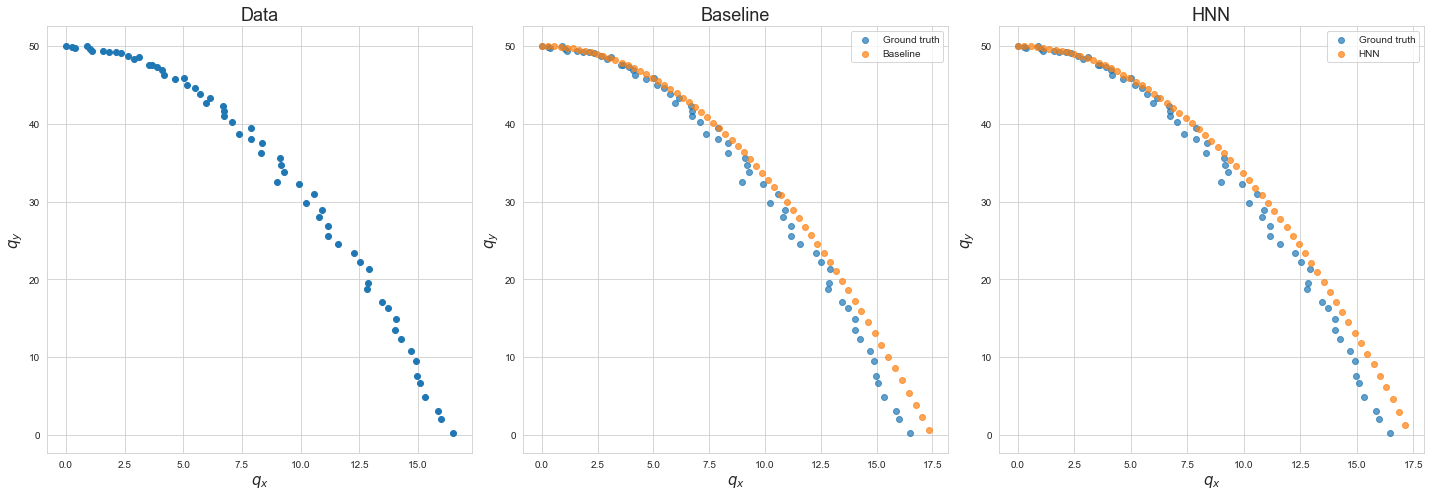

In [26]:
plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(test_X[0][:,0], test_X[0][:,1])
plt.title('Data', size=18)
plt.xlabel(r'$q_x$', size=15)
plt.ylabel(r'$q_y$', size=15)

plt.subplot(132)
plt.scatter(test_X[0][:,0], test_X[0][:,1], alpha=0.7, label='Ground truth')
plt.scatter(pred_baseline['y'][0], pred_baseline['y'][1], alpha=0.7, label='Baseline')
plt.title('Baseline', size=18)
plt.xlabel(r'$q_x$', size=15)
plt.ylabel(r'$q_y$', size=15)
plt.legend(loc='upper right')

plt.subplot(133)
plt.scatter(test_X[0][:,0], test_X[0][:,1], alpha=0.7, label='Ground truth')
plt.scatter(pred_hnn['y'][0], pred_hnn['y'][1], alpha=0.7, label='HNN')
plt.title('HNN', size=18)
plt.xlabel(r'$q_x$', size=15)
plt.ylabel(r'$q_y$', size=15)
plt.legend(loc='upper right')

plt.tight_layout()

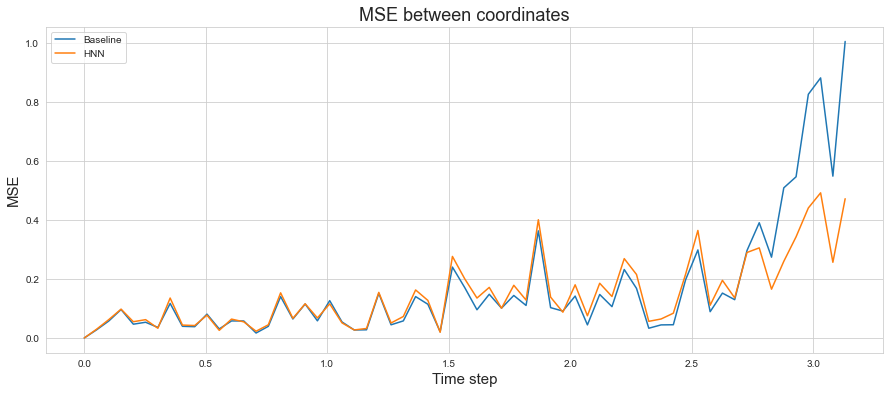

In [32]:
plt.figure(figsize=(15,6))

plt.plot(t_eval[:len(test_X[0])-1], ((test_X[0][:len(test_X[0])-1]-pred_baseline['y'].T[:len(test_X[0])])**2).mean(-1), label='Baseline')
plt.plot(t_eval[:len(test_X[0])-1], ((test_X[0][:len(test_X[0])-1]-pred_hnn['y'].T[:len(test_X[0])])**2).mean(-1), label='HNN')
plt.xlabel('Time step', size=15)
plt.ylabel('MSE', size=15)
plt.title('MSE between coordinates', size=18)
plt.legend()

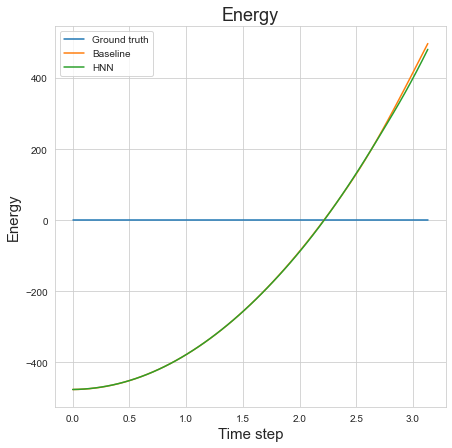

In [35]:
plt.figure(figsize=(7,7))

plt.plot(t_eval[:len(test_X[0])-1], [energies[0] for i in t_eval[:len(test_X[0])-1]], label='Ground truth')
plt.plot(t_eval[:len(test_X[0])-1], [hamiltonian(pred_baseline['y'].T[i]) for i in range(len(test_X[0])-1)], label='Baseline')
plt.plot(t_eval[:len(test_X[0])-1],  [hamiltonian(pred_hnn['y'].T[i]) for i in range(len(test_X[0])-1)], label='HNN')
plt.xlabel('Time step', size=15)
plt.ylabel('Energy', size=15)
plt.title('Energy', size=18)
plt.legend()